# Exploratory Data Analysis

---

This few-shot benchmark tests various meta-learning methods in the context of
biomedical applications. In particular, we are dealing with the [Tabula Muris]()
and [SwissProt]() datasets. One is a cell type classification task based on
single-cell gene expressions and the other is a protein function prediction task
based on protein sequences. The goal of this notebook is to explore basic
statistics about the two datasets, as well as understand how the data loading is
implemented for the episodic training during meta-training.


## Setup

---

First, let's import the relevant modules needed.


In [2]:
# ruff: noqa: E402
# Reload modules automatically
%reload_ext autoreload
%autoreload 2

# Module imports
import os
import sys
import time
import collections
import matplotlib.pyplot as plt
import seaborn as sns

# External imports
import numpy as np
import torch

In [3]:
# Add path to load local modules
sys.path.append("..")

# Set styles
sns.set_style("whitegrid")

## Base Classes

---

Both datasets are implemented as subclasses of the `FewShotDataset` class and
use some other generic utility classes. We will explore these here in detail.
They are all defined in the `datasets.dataset` module.


### FewShotDataset

The `FewShotDataset(torch.utils.data.Dataset)` is the base class for all
few-shot datasets. It implements the `__getitem__` and `__len__` methods and has
some utilities for checking the data validty. Furthermore, it is responsible for
loading and extracting the dataset into the `root` directory if specified and
not yet existent. However, as it is a abstract base class, it cannot be
instantiated, e.g. it requires the `_dataset_name` and `_dataset_dir` as class
attributes.


In [3]:
# Demo: FewShotDataset
from datasets.dataset import FewShotDataset  # noqa

try:
    few_shot_dataset = FewShotDataset()
except Exception as e:
    print(f"❌ Fails with error {e}.")

❌ Fails with error FewShotDataset must have attribute _dataset_name..


### FewShotSubDataset

The `FewShotSubDataset(torch.utils.data.Dataset)` is a class used for using only
a subset of samples that are in the same class in a PyTorch Dataset class. As we
will later see, it is used in combination with the `EpisodicBatchSampler` inside
the `TMSetDataset` and `SPSetDataset` to create episodic batches for
meta-training and meta-testing.

Code-wise, it simply wraps samples that are assumed to all be of a single class
inside a `torch.utils.Dataset`. This functionality is shown below.


In [4]:
# Demo FewShotSubDataset
from datasets.dataset import FewShotSubDataset  # noqa

# Create a random dataset with 100 samples, 5 features and 5 classes
samples = torch.rand(100, 5)
targets = torch.randint(0, 5, (100,))  # 5-way
subset_target = 4

# Get all samples that belong to class 4
subset_samples = samples[targets == subset_target]

# Create a few-shot dataset for class 4
few_shot_sub_dataset = FewShotSubDataset(subset_samples, subset_target)

# Sanity checks
assert (
    len(few_shot_sub_dataset) == (targets == subset_target).sum()
), "❌ Length of few-shot dataset is not correct."
assert (
    few_shot_sub_dataset.dim == samples.shape[1]
), "❌ Dimension of few-shot dataset is not correct."

### Episodic Batch Sampler

The `EpisodicBatchSampler` is a utility class that randomly samples `n_way`
classes (out of a totla of `n_classes`) for a total of `n_episodes`. It can be
used in episodic training to sample the classes used in each episode.

The sampler is `n_episodes` long and each time samples randomly (without
replacement) from `{0, ..., n_classes-1}` `n_way` times.


In [5]:
# Demo: EpisodicBatchSampler
from datasets.dataset import EpisodicBatchSampler  # noqa

# Demo of EpisodicBatchSampler
n_episodes, n_way, n_classes = 3, 5, 10
episodic_batch_sampler = EpisodicBatchSampler(n_classes, n_way, n_episodes)

print(f"Episodes: {n_episodes}, Ways: {n_way}, Classes: {n_classes}")
for batch_idx, indices in enumerate(episodic_batch_sampler):
    print(f"Episode {batch_idx+1} w/ classes {indices.numpy()}")

Episodes: 3, Ways: 5, Classes: 10
Episode 1 w/ classes [1 3 4 7 9]
Episode 2 w/ classes [9 3 7 6 5]
Episode 3 w/ classes [5 0 3 2 6]


## Tabula Muris

---

**Tabula Muris** is a dataset of single cell transcriptome data (gene
expressions) from mice, containing nearly `100,000` cells from `20` organs and
tissues. The data allow for direct and controlled comparison of gene expression
in cell types shared between tissues, such as immune cells from distinct
anatomical locations. They also allow for a comparison of two distinct technical
approaches:

_More Resources_:

- [Tabular Muris Website](https://tabula-muris.ds.czbiohub.org/)
- [SF Biohub Article](https://www.czbiohub.org/sf/tabula-muris/)


In [6]:
# This asssumes the data is already downloaded
!du -sh ../data/tabula_muris/*

 84M	../data/tabula_muris/gene_association.mgi
 32M	../data/tabula_muris/go-basic.obo
3.2G	../data/tabula_muris/processed
2.3G	../data/tabula_muris/tabula-muris-comet.h5ad


`gene_association.mgi` (`84 MB`): This file is associated with gene annotations,
specifically regarding mouse genes. The file likely contains information such as
gene identifiers, gene names, and possibly their associations with various
biological functions or diseases.

`go-basic.obo` (`32 MB`): This file is associated with the Gene Ontology (GO),
which is a major bioinformatics initiative to unify the representation of gene
and gene product attributes across all species. The ".obo" format (Open
Biomedical Ontologies format) is a text-based format used for ontologies. The
file likely contains GO terms and their definitions, including information on
biological processes, cellular components, and molecular functions.

`tabula-muris-comet.h5ad` (`2.3 GB`): The ".h5ad" extension suggests this file
is an AnnData file, a format commonly used in bioinformatics for storing large
annotated datasets, particularly single-cell data. AnnData files are based on
the HDF5 file format, which is designed for storing and organizing large amounts
of data. This particular file likely contains the main single-cell RNA
sequencing data from the Tabula Muris project, including gene expression
measurements for individual cells, metadata about the cells, and possibly
additional layers of data like spliced/unspliced gene counts or quality metrics.

As the combined size of the files is pretty large, even loading in the data
after downloading takes a while.


### MacaData

The `MacaData` class is responsible for loading and processing the Tabula Muris
dataset. Thus, before looking at the `TMSimpleDataset` and `TMSetDataset`, let's
investigate the data loading/ processing first.

**Changes to the original implementation:**

Originally, the class loads the entire dataset and processes it within the
constructor. This comes with several limitations:

1. We cannot easily look at the raw data.

2. We have to load and preprocess the entire dataset, even if we just want to
   use samples within a specific data split.

3. It does support any subsampling.

To account for this, the `MacaData` class has been augmented in the following
way.

1. Data processing is not performed inside the constructor but has to be called
   via public method `process_data`.

2. The processed data may now be saved to disk via the public method
   `save_data`.

To support efficient loading of subsets and splits of the data, we later also
implement the `MacaDataLoader` class which will be used to load the data during
training.


#### Raw Data

We first look at the raw data. The `MacaData` class expects the path to a
`.h5ad` file containing the data as input and loads the data as well as computes
the class mapping.


In [7]:
from datasets.cell.utils import MacaData  # noqa

path = os.path.join("..", "data", "tabula_muris", "tabula-muris-comet.h5ad")

start = time.time()
maca_data = MacaData(path=path)
print(f"⌛ Loaded data in {time.time() - start:.2f} seconds.")

⌛ Loaded data in 1.46 seconds.


In [8]:
# Save attributes
raw_data = maca_data.adata
trg2idx, idx2trg = maca_data.trg2idx, maca_data.idx2trg

The `MacaData` class stores the loaded data in the attribute `adata` (annotated
data) as an object of type `anndata.AnnData`. It is a data structure that stores
the data including annotations which is often used for bioinformatics data. We
can get detailled information about the data by printing the object.


In [9]:
# Print meta-data of entire dataset
raw_data

AnnData object with n_obs × n_vars = 164311 × 23341
    obs: 'FACS.selection', 'age', 'batch', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cellid', 'free_annotation', 'method', 'mouse.id', 'plate', 'sex', 'subtissue', 'tissue', 'well', 'cell_ontology_class_reannotated', 'free_annotation_reannotated', 'label'

We can view the annotation for each cell (sample) and each gene (feature) by
accessing the `obs` and `var` attributes of the `anndata.AnnData` object. The
`obs` attribute is a `pandas.DataFrame` with the cell annotations and the `var`
attribute is a `pandas.DataFrame` with the gene annotations.


In [10]:
# Cell annotations
raw_data.obs

,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,method,mouse.id,plate,sex,subtissue,tissue,well,cell_ontology_class_reannotated,free_annotation_reannotated,label
index,,,,,,,,,,,,,,,,,,
A10_B000235_B007504_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000235,nan,facs,18_53_M,B000235,male,Thymus Epithelium,Thymus,A10,nan,nan,88
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000497,nan,facs,18_53_M,B000497,male,nan,Skin,A10,bulge keratinocyte,nan,28
A10_B000524_B009242_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000524,nan,facs,18_53_M,B000524,male,nan,Trachea,A10,nan,nan,88
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,0,nan,nan,nan,A10_B000756,nan,facs,18_45_M,B000756,male,Endocrine,Pancreas,A10,pancreatic B cell,pancreatic B cell,98
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000802,nan,facs,18_47_F,B000802,female,Skin Anagen,Skin,A10,bulge keratinocyte,outer bulge,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P9_B000485_S69.mus-2-1,Multiple,18m,1,P9_B000485_S69.mus,nan,NA,nan,basal cell,facs,18_47_F,B000485,female,Mammary_Gland,Mammary_Gland,P9,basal cell,basal cell,20
P9_B000492_S153.mus-2-1,Multiple,18m,1,P9_B000492_S153.mus,nan,NA,nan,nan,facs,18_46_F,B000492,female,Mammary_Gland,Mammary_Gland,P9,basal cell,basal cell,20
P9_B000956_S237.mus-2-1,Multiple,21m,1,P9_B000956_S237.mus,nan,NA,nan,nan,facs,21_48_F,B000956,female,Mammary_Gland,Mammary_Gland,P9,nan,nan,88


We observe the meta data of each cell in the dataset. The meta data contains
information about the mic (like the id, gender, age, etc.) and the cell type
(like the cell type, (sub-)tissue, etc.) and much more. There are a total of
105.960 cells in the dataset.


In [11]:
# Gene annotations
raw_data.var

""
index
0610005C13Rik
0610007C21Rik
0610007L01Rik
0610007N19Rik
0610007P08Rik
...
Zzef1
Zzz3
a


In [12]:
# We can get the features and targets as numpy arrays (this is done in the TMDataset class as well)
feature_matrix = raw_data.X
targets = raw_data.obs["label"].cat.codes.to_numpy()

print(f"Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}")
print(f"Number of target tissues: {len(np.unique(targets))}")

Feature matrix: (164311, 23341), Targets: (164311,)
Number of target tissues: 125


Let's visualise the distribution of the target tissues by showing the top 10
most frequent tissues.


[Text(0, 0, 'nan'),
 Text(1, 0, 'microglial cell'),
 Text(2, 0, 'B cell'),
 Text(3, 0, 'endothelial cell'),
 Text(4, 0, 'mesenchymal stem cell of adipose'),
 Text(5, 0, 'basal cell of epidermis'),
 Text(6, 0, 'fibroblast of cardiac tissue'),
 Text(7, 0, 'skeletal muscle satellite cell'),
 Text(8, 0, 'endothelial cell of coronary artery'),
 Text(9, 0, 'bulge keratinocyte')]

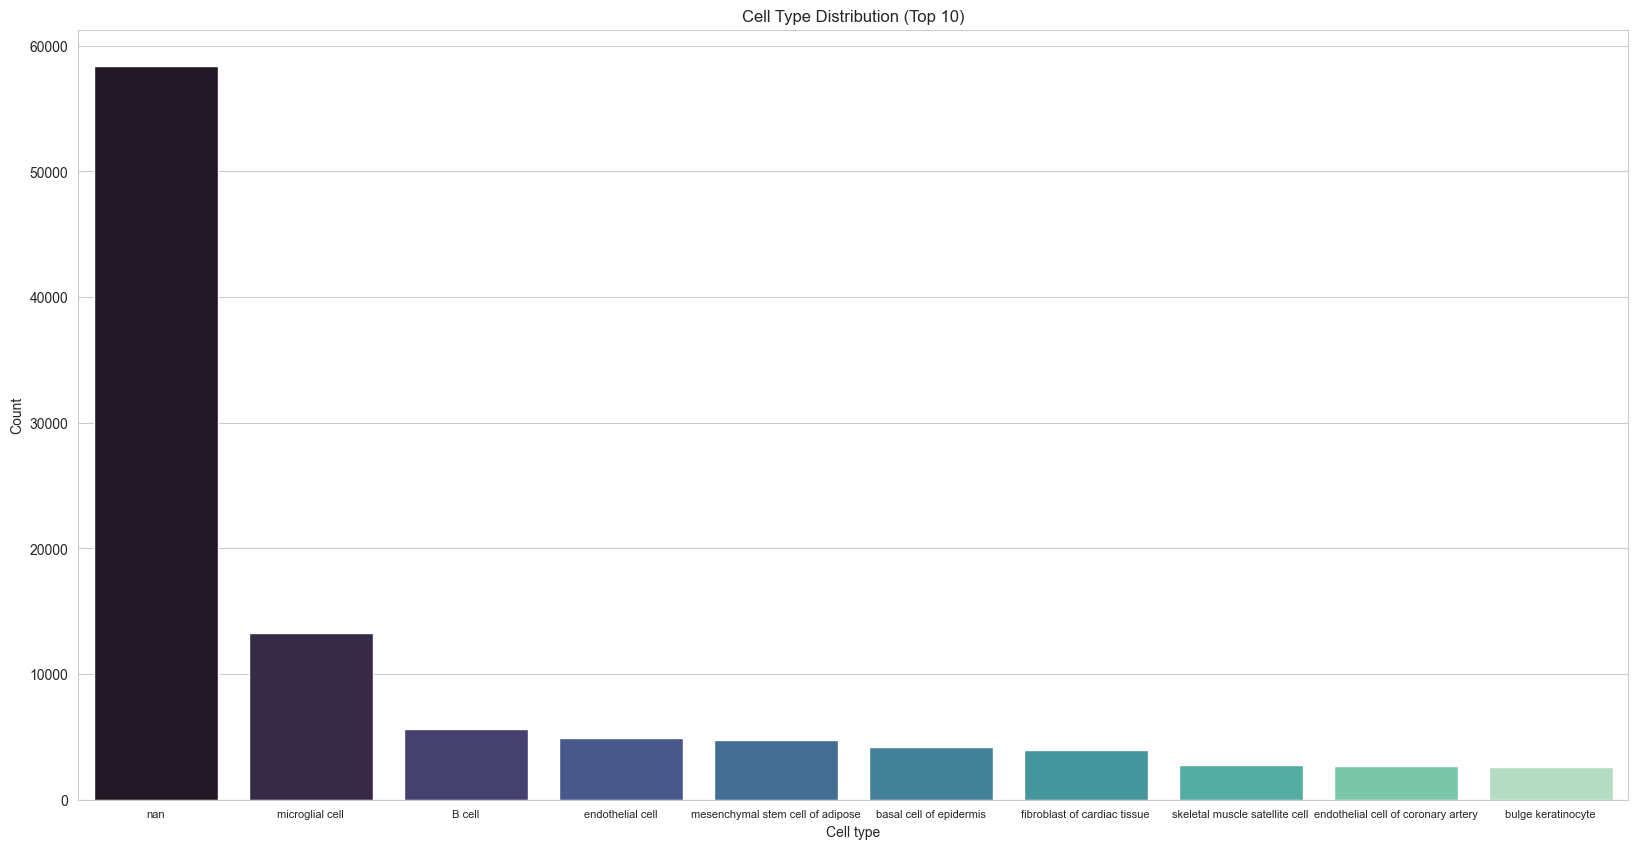

In [13]:
# Plot Cell Type Distribution
_, ax = plt.subplots(figsize=(20, 10))
cell_types = [maca_data.idx2trg[idx] for idx in targets]

top_k = 10
counts = collections.Counter(cell_types)
counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k])

sns.barplot(x=list(counts.keys()), y=list(

    counts.values()), palette="mako", ax=ax)
ax.set(
    xlabel="Cell type", ylabel="Count", title=f"Cell Type Distribution (Top {top_k})"
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

For each sample we record the gene expression levels for all genes. The gene
annotation contains some summary statistics about the expressivitiy of each
genes as meta data. The index in this data frame is the column names in the gene
expression feature matrix.


#### Pre-Processed Data

Let's preprocess the data according to the original implementation. The
following steps are performed in the `process_data` method:

- Filter out cells with no target
- Filter out genes that are expressed in less than 5 cells
- Filter out cells with less than 5000 counts and 500 genes expressed
- Normalize per cell (simple lib size normalization)
- Filter out genes with low dispersion (retain the once with high variance)
- Log transform and scale the data
- Zero-imputation of Nans


In [14]:
# Process data
start = time.time()
maca_data.process_data()
print(f"⌛ Processed data in {time.time() - start:.2f} seconds.")

⌛ Processed data in 19.73 seconds.


In [15]:
# Save attributes
processed_data = maca_data.adata
trg2idx, idx2trg = maca_data.trg2idx, maca_data.idx2trg

In [16]:
# Cell annotations
processed_data.obs

,FACS.selection,age,batch,cell,cell_ontology_class,cell_ontology_id,cellid,free_annotation,method,mouse.id,plate,sex,subtissue,tissue,well,cell_ontology_class_reannotated,free_annotation_reannotated,label,n_counts,n_genes
index,,,,,,,,,,,,,,,,,,,,
A10_B000497_B009023_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000497,nan,facs,18_53_M,B000497,male,nan,Skin,A10,bulge keratinocyte,nan,28,1009830.0,2706
A10_B000756_B007446_S10.mm10-plus-0-0,Viable,18m,0,nan,nan,nan,A10_B000756,nan,facs,18_45_M,B000756,male,Endocrine,Pancreas,A10,pancreatic B cell,pancreatic B cell,98,978772.0,3212
A10_B000802_B009022_S10.mm10-plus-0-0,Multiple,18m,0,nan,nan,nan,A10_B000802,nan,facs,18_47_F,B000802,female,Skin Anagen,Skin,A10,bulge keratinocyte,outer bulge,28,419809.0,2244
A10_B000927_B007456_S10.mm10-plus-0-0,"CD31+, CD45+, CD31-CD45-Sca1+, CD31-CD45-Sca1-...",18m,0,nan,nan,nan,A10_B000927,nan,facs,18_46_F,B000927,female,Muscle Diaphragm,Limb_Muscle,A10,skeletal muscle satellite cell,skeletal muscle satellite cell,114,878954.0,2790
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,0,nan,nan,nan,A10_B001361,nan,facs,18_46_F,B001361,female,RV,Heart,A10,B cell,B cell,0,6587.0,1237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P8_MAA001690_S20.mus-2-1,Multiple,21m,1,P8_MAA001690_S20.mus,basal cell,NA,nan,basal cell,facs,21_54_F,MAA001690,female,Mammary_Gland,Mammary_Gland,P8,basal cell,basal cell,20,146922.0,3523
P8_MAA001700_S104.mus-2-1,Multiple,21m,1,P8_MAA001700_S104.mus,basal cell,NA,nan,basal cell,facs,21_55_F,MAA001700,female,Mammary_Gland,Mammary_Gland,P8,basal cell,basal cell,20,1027607.0,4477
P9_B000485_S69.mus-2-1,Multiple,18m,1,P9_B000485_S69.mus,nan,NA,nan,basal cell,facs,18_47_F,B000485,female,Mammary_Gland,Mammary_Gland,P9,basal cell,basal cell,20,1184061.0,2980


In [17]:
# Gene annotations
processed_data.var

,n_cells,means,dispersions,dispersions_norm,highly_variable,mean,std
index,,,,,,,
0610010O12Rik,26900,0.595805,3.227825,1.181693,True,0.278420,0.610733
0610011F06Rik,28153,0.424729,2.704990,0.506945,True,0.224386,0.493771
0610040J01Rik,17814,0.450983,2.833664,0.673007,True,0.183069,0.531497
1100001G20Rik,5773,0.246094,2.818190,0.740441,True,0.064191,0.369087
1110002N22Rik,8695,0.143709,3.033060,0.953496,True,0.063313,0.284409
...,...,...,...,...,...,...,...
Zmiz1,43305,0.476539,3.767509,1.878184,True,0.251178,0.513480
Zranb1,21185,0.224852,2.820751,0.742980,True,0.113638,0.342801
Zscan20,1522,0.018424,2.899868,0.821429,True,0.007308,0.097050


In [18]:
# We can get the features and targets as numpy arrays (this is done in the TMDataset class as well)
feature_matrix = processed_data.X
targets = processed_data.obs["label"].cat.codes.to_numpy()

print(f"Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}")
print(f"Number of target tissues: {len(np.unique(targets))}")

Feature matrix: (105960, 2866), Targets: (105960,)
Number of target tissues: 124


[Text(0, 0, 'microglial cell'),
 Text(1, 0, 'B cell'),
 Text(2, 0, 'endothelial cell'),
 Text(3, 0, 'mesenchymal stem cell of adipose'),
 Text(4, 0, 'basal cell of epidermis'),
 Text(5, 0, 'fibroblast of cardiac tissue'),
 Text(6, 0, 'secretory cell'),
 Text(7, 0, 'endothelial cell of coronary artery'),
 Text(8, 0, 'bulge keratinocyte'),
 Text(9, 0, 'myeloid cell')]

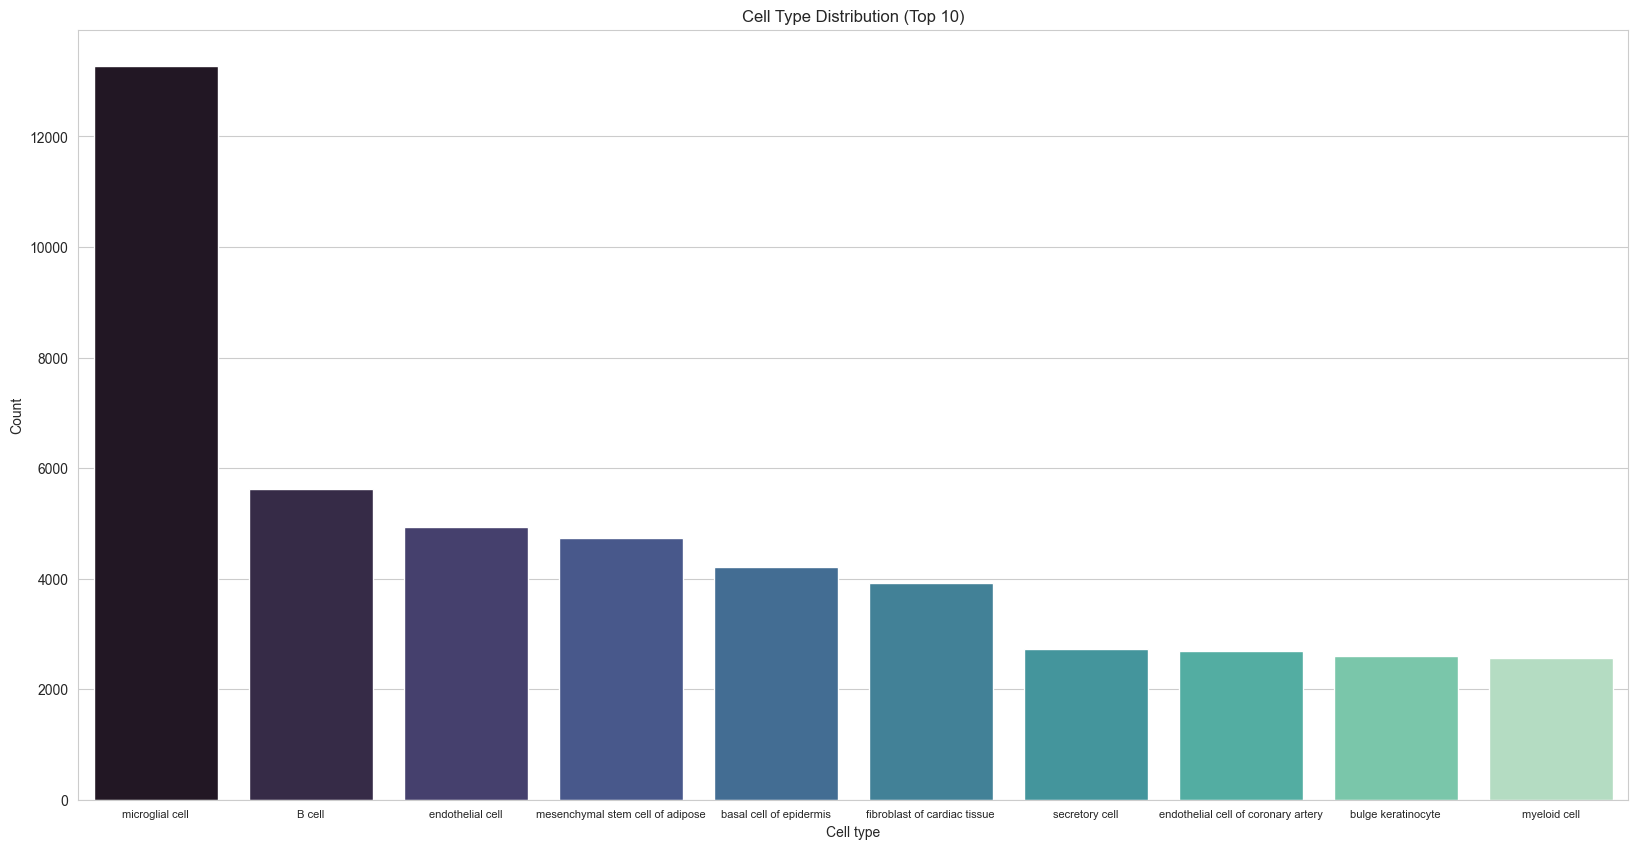

In [19]:
# Plot Cell Type Distribution
_, ax = plt.subplots(figsize=(20, 10))
cell_types = [maca_data.idx2trg[idx] for idx in targets]

top_k = 10
counts = collections.Counter(cell_types)
counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_k])

sns.barplot(x=list(counts.keys()), y=list(

    counts.values()), palette="mako", ax=ax)
ax.set(
    xlabel="Cell type", ylabel="Count", title=f"Cell Type Distribution (Top {top_k})"
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=8)

In [20]:
del maca_data, raw_data, processed_data

#### MacaDataLoader

The loading time for the entire dataset takes ~5 seconds while the processing
takes ~1.30 minutes. As this function is called on each instantiation of the
`TabulaMuris` dataset, we are loading the data in all splits in ~4.30 minutes.

As most of the time is spent on the processing, we can speed up the loading by
saving the processed data to disk. This is done in the `save_processed_data`
method in the `MacaData` class which is called within the `MacaDataLoader`
constructor.


The `MacaDataLoader` class then loads the data from the processed file path (or
processes the data if it does not exist using the above method internally).
Crucially, it supports subsetting and splitting of the data. The
`MacaDataLoader` class is used in the `TabulaMuris` dataset class to load the
data during training.


In [21]:
from datasets.cell.utils import MacaDataLoader

# Load data in splits
start = time.time()
train_maca_data = MacaDataLoader(path, mode="train", subset=False)
val_maca_data = MacaDataLoader(path, mode="val", subset=False)
test_maca_data = MacaDataLoader(path, mode="test", subset=False)
print(f"⌛ Loaded processed data in {time.time() - start:.2f} seconds.")

⌛ Loaded processed data in 13.13 seconds.


In [22]:
train_val_test_data = {
    "train": train_maca_data,
    "val": val_maca_data,
    "test": test_maca_data,
}

In [23]:
# We can get the features and targets as numpy arrays (this is done in the TMDataset class as well)
for mode, data in train_val_test_data.items():
    feature_matrix = data.adata.X
    targets = data.adata.obs["label"].cat.codes.to_numpy()

    print(
        f"{mode.capitalize()} Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}"
    )
    print(

        f"Number of {mode.capitalize()} target tissues: {len(np.unique(targets))}")
    print()

Train Feature matrix: (65846, 2866), Targets: (65846,)
Number of Train target tissues: 59

Val Feature matrix: (15031, 2866), Targets: (15031,)
Number of Val target tissues: 47

Test Feature matrix: (25083, 2866), Targets: (25083,)
Number of Test target tissues: 37



The loading and processing time for all splits now takes much less time.


In [24]:
# Sanity check: No overlapping tissues
train_tissues = train_maca_data.adata.obs.tissue.value_counts()
val_tissues = val_maca_data.adata.obs.tissue.value_counts()
test_tissues = test_maca_data.adata.obs.tissue.value_counts()

assert (
    set(train_tissues) & set(val_tissues) & set(test_tissues) == set()
), "❌ Splits have tissue overlap"
print("✅ Splits have no tissue overlap.")

✅ Splits have no tissue overlap.


For even faster experiment iteration we can use the `subset` flag in the
`MacaDataLoader` class which will randomly subset the data to 10% of the
original size. Let's show the loading of the subsetted train split for
demonstration purposes.


In [25]:
# Demo: MacaDataLoader with subset=True
start = time.time()
sub_train_maca_data = MacaDataLoader(path, mode="train", subset=True)
print(f"⌛ Loaded subsetted train data in {time.time() - start:.2f} seconds.")

feature_matrix = sub_train_maca_data.adata.X
targets = sub_train_maca_data.adata.obs["label"].cat.codes.to_numpy()
print(f"Feature matrix: {feature_matrix.shape}, Targets: {targets.shape}")
print(f"Number of train target tissues: {len(np.unique(targets))}")

⌛ Loaded subsetted train data in 6.16 seconds.
Feature matrix: (6584, 2866), Targets: (6584,)
Number of train target tissues: 59


Nice, we get 10% of the samples for each tissue although we are not doing
stratified sampling.


### TMSimpleDataset

The `TMSimpleDataset` inherits from the abstract `TMDataset` class which, in
turn, inherits from the generic `FewShotDataset` class. The `TMDataset` defines
the `_dataset_name` as `"tabula_muris"` and the `_dataset_url` and provides a
convenient loader utility which loads all samples and their targets. The
`TMSimpleDataset` initialises the data directory, loads the data and then does
the sanity checks from the base class. It provides the basic methods
`__getitem__`, `__len__`, the `dim` property.

Crucially, the data loader is tied to the dataset class and is available by
calling the `get_data_loader()` method. It will sample batches of size
`batch_size`.

_Note: Upon first call, the `TMSimpleDataset` class will download the data into
the `root` directory._


In [5]:
# Demo: TMSimpleDataset
from datasets.cell.tabula_muris import TMSimpleDataset  # noqa

# Arguments to provide
batch_size = 10  # Controls the batch_size of data loader
root = "../data"  # Controls where to store the data
min_samples = 20  # Filter out tissue types with less than min_samples

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

# Initialise TabulaMuris training dataset
data = {}
for mode in modes:
    start = time.time()
    tm_data = TMSimpleDataset(
        batch_size=batch_size, root=root, mode=mode, min_samples=min_samples
    )
    data[mode] = tm_data

    print(
        f"✅ TabulaMuris {mode} split loaded in {time.time() - start:.2f} seconds.")

✅ TabulaMuris train split loaded in 5.59 seconds.
✅ TabulaMuris val split loaded in 4.62 seconds.
✅ TabulaMuris test split loaded in 5.02 seconds.


In [6]:
# Statistics on the data splits
for split, dataset in data.items():
    print(f"ℹ️ Tabula Muris dataset has {len(dataset)} {split} samples.")

ℹ️ Tabula Muris dataset has 65812 train samples.
ℹ️ Tabula Muris dataset has 14962 val samples.
ℹ️ Tabula Muris dataset has 25065 test samples.


In [7]:
# Get sample by indexing
tr_smp, tr_trg = data["train"][0]

print(f"Training sample shape: {tr_smp.shape} and target {tr_trg}")

Training sample shape: (2866,) and target 51


Makes sense. Each sample in the processed data has 2866 features (gene
expression levels) and a single integer indicating the target tissue type.


In [8]:
# Get data loader
tm_train_loader = data["train"].get_data_loader(
    shuffle=True, num_workers=0, pin_memory=False
)

# Create iterator
tm_train_loader_iter = iter(tm_train_loader)

# Get five batches
for i in range(5):
    tr_smps, tr_trgs = next(tm_train_loader_iter)
    print(f"Training batch shape: {tr_smps.shape} and target {tr_trgs}")

Training batch shape: torch.Size([10, 2866]) and target tensor([42, 10, 39, 37, 40,  9, 38, 24, 38, 38], dtype=torch.int32)
Training batch shape: torch.Size([10, 2866]) and target tensor([38, 32,  0, 38, 11, 33, 25, 38, 24, 40], dtype=torch.int32)
Training batch shape: torch.Size([10, 2866]) and target tensor([51,  2, 51, 39, 23, 13, 39, 16, 51, 24], dtype=torch.int32)
Training batch shape: torch.Size([10, 2866]) and target tensor([ 0, 16, 45, 17, 48,  0, 24, 17, 42, 37], dtype=torch.int32)
Training batch shape: torch.Size([10, 2866]) and target tensor([39, 46, 39,  0,  8, 39,  9,  9, 11, 38], dtype=torch.int32)


**NB 1:** On CPU setting `num_workers=0` and `pin_memory=False` is recommended
and loads the batches instant. However, the original parameters in the code are
`num_workers=4` and `pin_memory=True` which is likely GPU optimised. To have
full control, the signature of the `get_data_loader` method has been changed to
allow for customisation of the data loader.

**NB 2:** Shuffling the data is crucial during training for regular fine-tuning.
The raw data does not seem to be shuffled well which will likely hurt the
training.


### TMSetDataset

The `TMSetDataset` is designed for few-shot learning. Most configurations are
the same as for the `TMSimpleDataset`, but crucially the dataset class will
return an episodic batch sampler based on the `n_way`, `n_support`, `n_query`
and parameters.


In [9]:
# Demo: TMSetDataset
from datasets.cell.tabula_muris import TMSetDataset  # noqa

# Arguments to provide
batch_size = 10  # Controls the batch_size of data loader
root = "../data"  # Controls where to store the data
min_samples = 20  # Filter out tissue types with less than min_samples
n_way = 5  # Controls the number of classes to distinguish
n_support = 3  # Controls the number of support samples per class
n_query = 3  # Controls the number of query samples per class

# Controls data split (returns subset of tissue types)
modes = ["train", "val", "test"]

# Initialise TabulaMuris training dataset
data = {}

for mode in modes:
    start = time.time()
    tm_data = TMSetDataset(
        n_way=n_way,
        n_support=n_support,
        n_query=n_query,
        root=root,
        mode=mode,
    )
    data[mode] = tm_data

    print(
        f"✅ TMSetDataset {mode} split loaded in {time.time() - start:.2f} seconds.")

✅ TMSetDataset train split loaded in 6.85 seconds.
✅ TMSetDataset val split loaded in 4.56 seconds.
✅ TMSetDataset test split loaded in 5.13 seconds.


In a few-shot learning dataset, a single "sample" is defined not as the feature
vector, target tuple of the gene expression levels and the target tissue but as
a set of support and query samples within a class. Thus, the `__getitem__`
method returns a tuple of the support and query samples and targets for the
`i`-th class. Thus, the returned tensor dimension will be
`(n_support + n_query, n_features)` for the samples and
`(n_support + n_query, )` for the targets.


In [10]:
# Get sample by indexing
tr_smp, tr_trg = data["train"][0]

# Support samples and target
sup_tr_smp, sup_tr_trg = tr_smp[:n_support], tr_trg[:n_support]

# Query samples and target
que_tr_smp, que_tr_trg = tr_smp[n_support:], tr_trg[n_support:]

print(f"Training samples shape: {tr_smp.shape} and target {tr_trg}")
print(f"Support samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")
print(f"Query samples shape: {sup_tr_smp.shape} and target {sup_tr_trg}")

Training samples shape: torch.Size([6, 2866]) and target tensor([0, 0, 0, 0, 0, 0], dtype=torch.int32)
Support samples shape: torch.Size([3, 2866]) and target tensor([0, 0, 0], dtype=torch.int32)
Query samples shape: torch.Size([3, 2866]) and target tensor([0, 0, 0], dtype=torch.int32)


Next, the data loader class combines the support-query sampler per class (as
defined above) and the `EpisodicBatchSampler` to create a data loader that
returns batches of episodes where each time we get `n_way` classes with
`n_support` support samples and `n_query` query samples per class. First, the
episodic batch sample samples the `n_way` random class indices and then the
support-query sampler samples the support and query samples for each class.
Thus, the final tensor shapes will be `(n_way, n_query + n_support, n_features)`
for the samples and `(n_way, n_query + n_support, )` for the targets.


In [11]:
# Get data loader
train_loader = data["train"].get_data_loader(num_workers=0, pin_memory=False)

# Get batch
tr_smps, tr_trgs = next(iter(train_loader))

print(f"Training batch shape: {tr_smps.shape} and target {tr_trgs.shape}")
print(f"Targets:\n{tr_trgs}")

Training batch shape: torch.Size([5, 6, 2866]) and target torch.Size([5, 6])
Targets:
tensor([[37, 37, 37, 37, 37, 37],
        [53, 53, 53, 53, 53, 53],
        [22, 22, 22, 22, 22, 22],
        [ 6,  6,  6,  6,  6,  6],
        [13, 13, 13, 13, 13, 13]], dtype=torch.int32)


**NB 1:** Shuffling in meta-learning tasks is not necessary because the episodic
batch sampler and the sub-class sampler are already random.


## SwissProt

---

SWISS-PROT is an annotated protein sequence database, which was created at the
Department of Medical Biochemistry of the University of Geneva (first started
1987). In SWISS-PROT two classes of data can be distinguished: the core data and
the annotation. For each sequence entry the core data consists of the sequence
data; the citation information (bibliographical references) and the taxonomic
data (description of the biological source of the protein), while the annotation
consists of the description of the following items:

- Function(s) of the protein
- Post-translational modification(s). For example carbohydrates,
  phosphorylation, acetylation, GPI-anchor, etc.
- Domains and sites. For example calcium binding regions, ATP-binding sites,
  zinc fingers, homeoboxes, SH2 and SH3 domains, etc.
- Secondary structure. For example alpha helix, beta sheet, etc.
- Quaternary structure. For example homodimer, heterotrimer, etc.
- Similarities to other proteins
- Disease(s) associated with deficiencie(s) in the protein
- Sequence conflicts, variants, etc.

_More Resources_:

- [National Library of Medicine](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC102476/)


In [ ]:
from datasets.prot.swissprot import SPSimpleDataset, SPSetDataset